# Finding Musical Genres


## Purpose of Notebook
In this notebook we will be trying to cluster the tracks in my Spotify library into genres and create playlists based on the genres.    

## Related Notebooks

1. [Data Retrieval](https://github.com/rtedwards/spotify-data-visualizations/blob/master/spotify-data-visualizations/spotify-data-retrieval.ipynb) walks through collecting liked tracks using Spotipy as a Python wrapper for the Spotify API and attaching audio features to each track and storing in a dataframe.
2. [Data Exploration](https://github.com/rtedwards/spotify-data-visualizations/blob/master/spotify-data-visualizations/spotify-data-exploration.ipynb) is an exploratory data analysis of my liked tracks
3. **[Data Clustering](https://github.com/rtedwards/spotify-data-visualizations/blob/master/spotify-data-visualizations/spotify-data-clustering.ipynb)**  attempts to finds genres in my liked tracks using K-Means clustering from 


## Resources

+ [official Spotify Web API](https://developer.spotify.com/documentation/web-api/) 


### Spotify Web API
Spotify has a number of [API endpoints](https://developer.spotify.com/documentation/web-api/reference-beta/) available to access the Spoitfy data.  In this notebook, I use the following endpoints:

+ [search endpoint](https://developer.spotify.com/documentation/web-api/reference/search/search/) to get the track IDs
+ [audio features endpoint](https://developer.spotify.com/documentation/web-api/reference/tracks/get-several-audio-features/) to get the corresponding audio features.


### K-Means Clustering

K-Means is intuitive and computationally fast that works well on spherical data (i.e. "blobs").  In the last notebook we saw that the data looked more like skewed blobs or a singular blob possibly indicating that K-Means may not find many clusters.  Agglomerative Hierarchical Clustering may work better as we can choose different linkage methods.  However, we will proceed with K-Means and see how it does.

+ [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do)
+ [Clustering Algorithms](https://scikit-learn.org/stable/modules/clustering.html#dbscan)


In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()  # for plot styling
from IPython.display import IFrame  # for embedding Spotify player
from sklearn.cluster import KMeans

First, we need to import the data:

In [3]:
df = pd.read_csv('data/saved-songs.csv')

In [4]:
df_features = df[['popularity','acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'duration_ms', 'valence']]

In [5]:
def normalize(X):
    dataNorm=((X-X.min())/(X.max()-X.min()))
    return dataNorm

df_features = normalize(df_features)
df_features.sample(5)

,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,duration_ms,valence
1781,0.465909,0.023713,0.553626,0.895632,0.000000,0.119304,0.948962,0.073002,0.593380,0.041572,0.303590
2798,0.420455,0.000062,0.563841,0.870543,0.149646,0.084485,0.876020,0.094168,0.473036,0.058690,0.351795
13,0.477273,0.961809,0.346272,0.230283,0.959555,0.066052,0.566711,0.044168,0.412250,0.102665,0.182564
318,0.204545,0.004095,0.802860,0.499232,0.943377,0.099846,0.611773,0.056587,0.556543,0.083733,0.298462
2633,0.227273,0.089442,0.460674,0.621664,0.000008,0.142857,0.888988,0.046328,0.408225,0.075314,0.210256


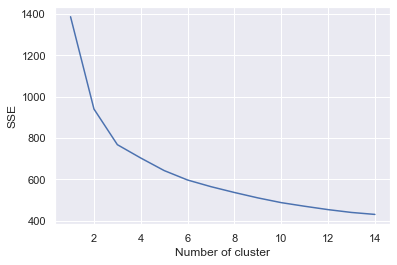

In [6]:
sse = {}
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=2, max_iter=1000).fit(df_features)
#    df_features["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

From the elbow plot we see no clear "elbow" except maybe at 3 clusters.  However, only three clusters would allow for a considerate amount of overlap of the genres in each cluster.  We can see another slight elbow at 6 clusters so let's use that.

In [7]:
kmeans = KMeans(n_clusters = 6)
kmeans.fit(df_features)
y_kmeans = kmeans.predict(df_features)

In [8]:
df['genre'] = y_kmeans
df['genre'] = df['genre'].astype('category') # cast a categorical variable
df.head()

,Unnamed: 0,artist_name,track_name,track_id,popularity,acousticness,analysis_url,danceability,duration_ms,energy,...,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence,genre
0,0,Cubicolor,Fictionalise - Lindstrom & Prins Thomas Extend...,1m8BthDjfQS47iuULONgLi,12,0.0510,https://api.spotify.com/v1/audio-analysis/1m8B...,0.635,583263,0.829,...,-8.771,0,0.0415,116.989,4,https://api.spotify.com/v1/tracks/1m8BthDjfQS4...,audio_features,spotify:track:1m8BthDjfQS47iuULONgLi,0.6360,2
1,1,Cubicolor,Fictionalise - Lindstrom & Prins Thomas Remix,40X549muIHXIvWoj2S6MKb,16,0.1350,https://api.spotify.com/v1/audio-analysis/40X5...,0.616,312301,0.863,...,-10.520,0,0.0377,116.978,4,https://api.spotify.com/v1/tracks/40X549muIHXI...,audio_features,spotify:track:40X549muIHXIvWoj2S6MKb,0.5270,2
2,2,Cubicolor,Dead End Thrills - Patrice Bäumel Remix,3MEjDXwQWnDzqwRanBgFzm,37,0.2800,https://api.spotify.com/v1/audio-analysis/3MEj...,0.700,443661,0.673,...,-10.217,1,0.0374,122.008,3,https://api.spotify.com/v1/tracks/3MEjDXwQWnDz...,audio_features,spotify:track:3MEjDXwQWnDzqwRanBgFzm,0.1430,0
3,3,Cubicolor,Counterpart,2Jm5TBQziCdySQg2J7w0PN,33,0.4200,https://api.spotify.com/v1/audio-analysis/2Jm5...,0.361,314043,0.471,...,-12.726,1,0.0441,122.845,4,https://api.spotify.com/v1/tracks/2Jm5TBQziCdy...,audio_features,spotify:track:2Jm5TBQziCdySQg2J7w0PN,0.0392,1
4,4,Cubicolor,No Dancers,6NH78lyZkS05PotKqg0ZKw,45,0.0146,https://api.spotify.com/v1/audio-analysis/6NH7...,0.577,347717,0.853,...,-11.989,0,0.0384,119.988,4,https://api.spotify.com/v1/tracks/6NH78lyZkS05...,audio_features,spotify:track:6NH78lyZkS05PotKqg0ZKw,0.1400,4


From just looking directly at the raw data it is difficult to determine how representative each cluster is to a genre.  So instead, we will make playlists from each cluster so we can listen to them!

# Creating Playlists

We will need to create another Spotify API token with the correct scope to allow us to create and save a playlist to my Spotify library.

In [13]:
# Make sure that app.js from authorization_code directory is running
# node app.js

# API scopes
'''
user-read-private \
user-read-email \
user-read-recently-played \
user-read-playback-state \
user-read-currently-playing \
user-library-read \
playlist-modify-public \
playlist-read-private \
user-follow-read \
user-top-read streaming
'''

import os
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util


# Retreive client_id and _client_secret from environment variables
CLIENT_ID = os.getenv('SPOTIFY_CLIENT_ID')
CLIENT_SECRET = os.getenv('SPOTIFY_CLIENT_SECRET')
REDIRECT_URI = "http://localhost/2222/callback/"
USERNAME = "1266075212"
#username = "UGGN-mPDSl6K8SoSPtYCEQ"  # You can checkout my profile if you are really curious
SCOPE = 'user-library-read \
        playlist-modify-public \
        playlist-modify-private \
        playlist-read-private' 

# Setting Spotify Client Credentials
#client_credentials_manager = SpotifyClientCredentials(client_id=CLIENT_ID, 
#                                                      client_secret=CLIENT_SECRET)
#sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Retrieving API token
token = util.prompt_for_user_token(username = USERNAME, 
                                   scope = SCOPE, 
                                   client_id = CLIENT_ID, 
                                   client_secret = CLIENT_SECRET, 
                                   redirect_uri = REDIRECT_URI)
if token:
   sp = spotipy.Spotify(auth=token)

# For each level in "genre" create a playlist and add all tracks in that genre
if token:
    # save API token
    sp = spotipy.Spotify(auth=token)
    playlist_id = []
    num_playlists = len(df['genre'].cat.categories)
    for i in range(0, num_playlists):
        print("Creating playlist from Cluster", i)
        # Create a new playlist
        playlist_name = 'Cluster ' + str(df['genre'].cat.categories[i])
        playlist_id.append(sp.user_playlist_create(USERNAME, playlist_name, public=True))
        
        # Subsetting data frame by genre
        df_genre = df[df['genre'] == i]
        tracks = list(df_genre['track_id'])
        #tracks = df_genre['uri'].tolist()
        
        # Add tracks to playlist
        batchsize = 100
        for j in range(0, len(tracks), batchsize):
            add_track = tracks[j]
            sp.user_playlist_add_tracks(USERNAME, playlist_id[i]['id'], tracks[i:i+batchsize], position=None)
        
        
else:
    print("Can't get token for", username)


Creating playlist from Cluster 0
Creating playlist from Cluster 1
Creating playlist from Cluster 2
Creating playlist from Cluster 3
Creating playlist from Cluster 4
Creating playlist from Cluster 5


Now we listen to our newly created playlists 😃

In [213]:
# Formatting for Spotify web players
from IPython.display import display, HTML
CSS = """
.output {
    flex-direction: row;
    flex-wrap: wrap;
}
"""
HTML('<style>{}</style>'.format(CSS))

In [16]:
for i in range(0, len(playlist_id)):
    playlist_url = "https://open.spotify.com/embed/playlist/" + playlist_id[i]['id']
    display(IFrame(src=playlist_url, width=300, height=380))

It seems that generally, these playlists are senisble.  Though playlists seem to have large overlap or just flat out group tracks together that I would never think to put together -- Cubicolor with Metallica (even if it is the SF Symphony version) just seems plain wrong.  That just means there is room for improvement!  

# What's Next?

We have made some clusters from the data and created playlists from them.  Where do we go from here?  There are a few things we can begin to look into:

+ First off, these playlists are HUGE.  We 
+ We can try another clustering algorithm that can use continuous and categorical data so we can use the `key` and `mode` audio features.  
+ We can also try to find subgenres in the clusters we just found such as: "house", "techno", "trance", "trap", "bass" under the "electronic" genre.  We can take it even further and try to find even more subgenres in those subgenres such as: "big-room house", "deep house", "tropical house", "acid house", and "progressive house".  We may start to run into problems involving sparsity of data however.
+ We can try to find more features for the Spotify tracks, potential using the [Spotify Audio Analysis](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-analysis/) API endpoint.  The audio analysis gives more insight into what's happening as discrete points in the song and could allow us to find more subtleties in the tracks. 


1. [Data Retrieval](https://github.com/rtedwards/spotify-data-visualizations/blob/master/spotify-data-visualizations/spotify-data-retrieval.ipynb) walks through collecting liked tracks using Spotipy as a Python wrapper for the Spotify API and attaching audio features to each track and storing in a dataframe.
2. [Data Exploration](https://github.com/rtedwards/spotify-data-visualizations/blob/master/spotify-data-visualizations/spotify-data-exploration.ipynb) is an exploratory data analysis of my liked tracks
3. [Data Clustering](https://github.com/rtedwards/spotify-data-visualizations/blob/master/spotify-data-visualizations/spotify-data-clustering.ipynb)  attempts to finds genres in my liked tracks using K-Means clustering
